## Blinded cameras clustering

Here the dataset is a pandas DataFrame generated from a response.drdf file. 
The file can be found at "/storage/gpfs_data/neutrino/SAND-LAr/SAND-LAr-GRAIN-CALORIMETRY/data/cube_production/production1/cube_X0_Y0_Z-3/output/response_cut.drdf".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans
import skimage
from joblib import Parallel, delayed

### Read data from pickle format

Compose data array from dataframe column, keeping different cameras in the rows, while columns represent the pixels

In [2]:
#module_path = os.path.abspath(os.path.join('..'))
df = pd.read_pickle("blind_cameras_dataset\\drdf_arrays.pkl")

df2arr = df.pixels.to_numpy()
arr3d = np.stack(df2arr)
data = arr3d.reshape(df2arr.shape[0],32*32)


In [3]:
# NB this os the proof of how the reshape method works!!
# t0 = test[0]
# t1 = test1[0]
# d = np.empty(0)
# for i in range(32):
#     for j in range(32):
#         diff = t0[i,j] - t1[i*32+j]
#         d = np.apltend(d,diff)
        
# print(np.min(d), np.max(d))

### Show distribution of data from the entire file

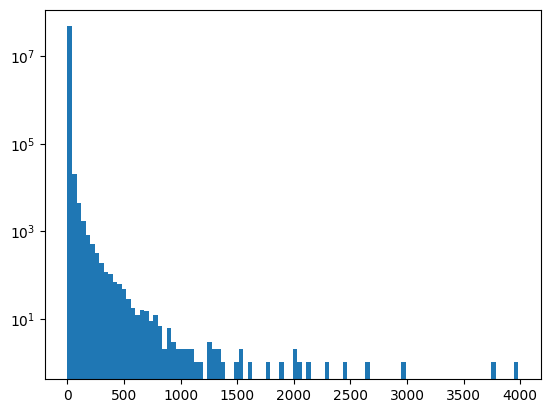

In [4]:
plt.hist(data.reshape(-1,1),100)
plt.yscale('log')

### Filter data

In [3]:
def task(camera):
    thr = skimage.filters.threshold_minimum(image=camera, nbins=1024, max_num_iter=1000000)
    return thr

filter = False

if filter:
    thresholds = Parallel(n_jobs=5)(delayed(task)(i) for i in arr3d[:2000])
    
    print(thresholds)
    thr = np.array(thresholds).reshape(-1,1)
    filt = (data[:1000] > thr)*thr
    filt.shape

N.B. takes 14 min

In [4]:
if not filter:
    hess = skimage.filters.hessian(arr3d)
    hess.shape
    filt = (hess*arr3d).reshape(-1,1024)

### Find probable blinded cameras through simple amplitude considerations

In [5]:
index = np.empty(0)

for img in arr3d:
    if (np.amax(img) > 40):
        if (np.amax(img)/np.mean(img) > 7):
            index = np.append(index, 1)
        else :
            index = np.append(index, 0) 
    else :
        index = np.append(index, 0) 
        
print(index[index == 1].size, 'over', arr3d.shape[0])
assigned_blind = arr3d[np.where(index == 1)]
#print(np.where(index == 1))

491 over 46968


### Use the KMean algorithm to clusterise the datasample.
The same data are the processed to check the clusterization.

In [23]:
# Declaring Model
# model = KMeans(n_clusters=3)
# model2 = KMeans(init="random", n_clusters=3, n_init=20, random_state=0)
# model2 = KMeans(init="k-means++", n_clusters=3, n_init=20, random_state=0)
model = KMeans(init="k-means++", n_clusters=8, n_init=20, random_state=0)
# Fitting Model
# model.fit(data)
# model2.fit(data)
# model2.fit(data)
model.fit(filt)

# print(np.count_nonzero(model2.labels_ == 0), np.count_nonzero(model2.labels_ == 1), np.count_nonzero(model1.labels_ == 2))
# print(np.count_nonzero(model2.labels_ == 0), np.count_nonzero(model2.labels_ == 1), np.count_nonzero(model2.labels_ == 2))
print(np.count_nonzero(model.labels_ == 0), np.count_nonzero(model.labels_ == 1), np.count_nonzero(model.labels_ == 2), np.count_nonzero(model.labels_ == 3), np.count_nonzero(model.labels_ == 4), np.count_nonzero(model.labels_ == 5), np.count_nonzero(model.labels_ == 6), np.count_nonzero(model.labels_ == 7))

lb3 = model.predict(filt)

45684 131 2 1 1 1 1135 13


#### Model evaluation

In [46]:
clustered_blind_idx = np.where((lb3 == 1) | (lb3 == 2) | (lb3 == 3) | (lb3 == 4) | (lb3 == 5) | (lb3 == 6) | (lb3 == 7))[0]

common_cameras = np.intersect1d(clustered_blind_idx, np.where(index == 1))
print('positive total :', clustered_blind_idx.shape[0])
print('predicted positive :', assigned_blind.shape[0])
print('true positive =', common_cameras.shape[0], '/', clustered_blind_idx.shape[0], '=', common_cameras.shape[0]/clustered_blind_idx.shape[0]*100, '%')
print('false positive =', clustered_blind_idx.shape[0] - common_cameras.shape[0], '/', clustered_blind_idx.shape[0], '=', (clustered_blind_idx.shape[0] - common_cameras.shape[0])/clustered_blind_idx.shape[0]*100, '%')
print('cluster 0 :',np.intersect1d(np.where(lb3 == 0), np.where(index == 1)).shape[0], '/',np.where(lb3 == 0)[0].size)
print('cluster 1 :',np.intersect1d(np.where(lb3 == 1), np.where(index == 1)).shape[0], '/',np.where(lb3 == 1)[0].size)
print('cluster 2 :',np.intersect1d(np.where(lb3 == 2), np.where(index == 1)).shape[0], '/',np.where(lb3 == 2)[0].size)
print('cluster 3 :',np.intersect1d(np.where(lb3 == 3), np.where(index == 1)).shape[0], '/',np.where(lb3 == 3)[0].size)
print('cluster 4 :',np.intersect1d(np.where(lb3 == 4), np.where(index == 1)).shape[0], '/',np.where(lb3 == 4)[0].size)
print('cluster 5 :',np.intersect1d(np.where(lb3 == 5), np.where(index == 1)).shape[0], '/',np.where(lb3 == 5)[0].size)
print('cluster 6 :',np.intersect1d(np.where(lb3 == 6), np.where(index == 1)).shape[0], '/',np.where(lb3 == 6)[0].size)
print('cluster 7 :',np.intersect1d(np.where(lb3 == 7), np.where(index == 1)).shape[0], '/',np.where(lb3 == 7)[0].size)


positive total : 1284
predicted positive : 491
true positive = 391 / 1284 = 30.45171339563863 %
false positive = 893 / 1284 = 69.54828660436138 %
cluster 0 : 100 / 45684
cluster 1 : 60 / 131
cluster 2 : 2 / 2
cluster 3 : 1 / 1
cluster 4 : 1 / 1
cluster 5 : 1 / 1
cluster 6 : 318 / 1135
cluster 7 : 8 / 13


#### Attempt for a second filter

In [52]:
new_filt = filt[np.where(lb3 == 6)[0]]
new_arr3d = arr3d[np.where(lb3 == 6)[0]]

model1 = KMeans(init="k-means++", n_clusters=3, n_init=20, random_state=0)
model1.fit(new_filt)
print(np.count_nonzero(model1.labels_ == 0), np.count_nonzero(model1.labels_ == 1), np.count_nonzero(model1.labels_ == 2), np.count_nonzero(model1.labels_ == 3))
lb1 = model1.predict(new_filt)

index1 = np.empty(0)

for img in new_arr3d:
    if (np.amax(img) > 40):
        if (np.amax(img)/np.mean(img) > 7):
            index1 = np.append(index1, 1)
        else :
            index1 = np.append(index1, 0) 
    else :
        index1 = np.append(index1, 0) 
        
print(index1[index1 == 1].size, 'over', new_arr3d.shape[0])
assigned_blind1 = new_arr3d[np.where(index1 == 1)]

print('cluster 0 :',np.intersect1d(np.where(lb1 == 0), np.where(index1 == 1)).shape[0], '/',np.where(lb1 == 0)[0].size)
print('cluster 1 :',np.intersect1d(np.where(lb1 == 1), np.where(index1 == 1)).shape[0], '/',np.where(lb1 == 1)[0].size)
print('cluster 2 :',np.intersect1d(np.where(lb1 == 2), np.where(index1 == 1)).shape[0], '/',np.where(lb1 == 2)[0].size)
print('cluster 3 :',np.intersect1d(np.where(lb1 == 3), np.where(index1 == 1)).shape[0], '/',np.where(lb1 == 3)[0].size)



255 879 1 0
318 over 1135
cluster 0 : 101 / 255
cluster 1 : 216 / 879
cluster 2 : 1 / 1
cluster 3 : 0 / 0


#### re-filter non-blinded cluster

In [ ]:
new_new_filt = filt[np.where(lb3 == 0)[0]]
new_new_arr3d = arr3d[np.where(lb3 == 0)[0]]

model2 = KMeans(init="k-means++", n_clusters=3, n_init=20, random_state=0)
model2.fit(new_filt)
print(np.count_nonzero(model2.labels_ == 0), np.count_nonzero(model2.labels_ == 1), np.count_nonzero(model2.labels_ == 2), np.count_nonzero(model2.labels_ == 3))
lb2 = model2.predict(new_new_filt)

index2 = np.empty(0)

for img in new_new_arr3d:
    if (np.amax(img) > 40):
        if (np.amax(img)/np.mean(img) > 7):
            index2 = np.append(index2, 1)
        else :
            index2 = np.append(index2, 0) 
    else :
        index2 = np.append(index2, 0) 
        
print(index2[index2 == 1].size, 'over', new_new_arr3d.shape[0])
assigned_blind1 = new_new_arr3d[np.where(index2 == 1)]

print('cluster 0 :',np.intersect1d(np.where(lb2 == 0), np.where(index2 == 1)).shape[0], '/',np.where(lb2 == 0)[0].size)
print('cluster 1 :',np.intersect1d(np.where(lb2 == 1), np.where(index2 == 1)).shape[0], '/',np.where(lb2 == 1)[0].size)
print('cluster 2 :',np.intersect1d(np.where(lb2 == 2), np.where(index2 == 1)).shape[0], '/',np.where(lb2 == 2)[0].size)
print('cluster 3 :',np.intersect1d(np.where(lb2 == 3), np.where(index2 == 1)).shape[0], '/',np.where(lb2 == 3)[0].size)


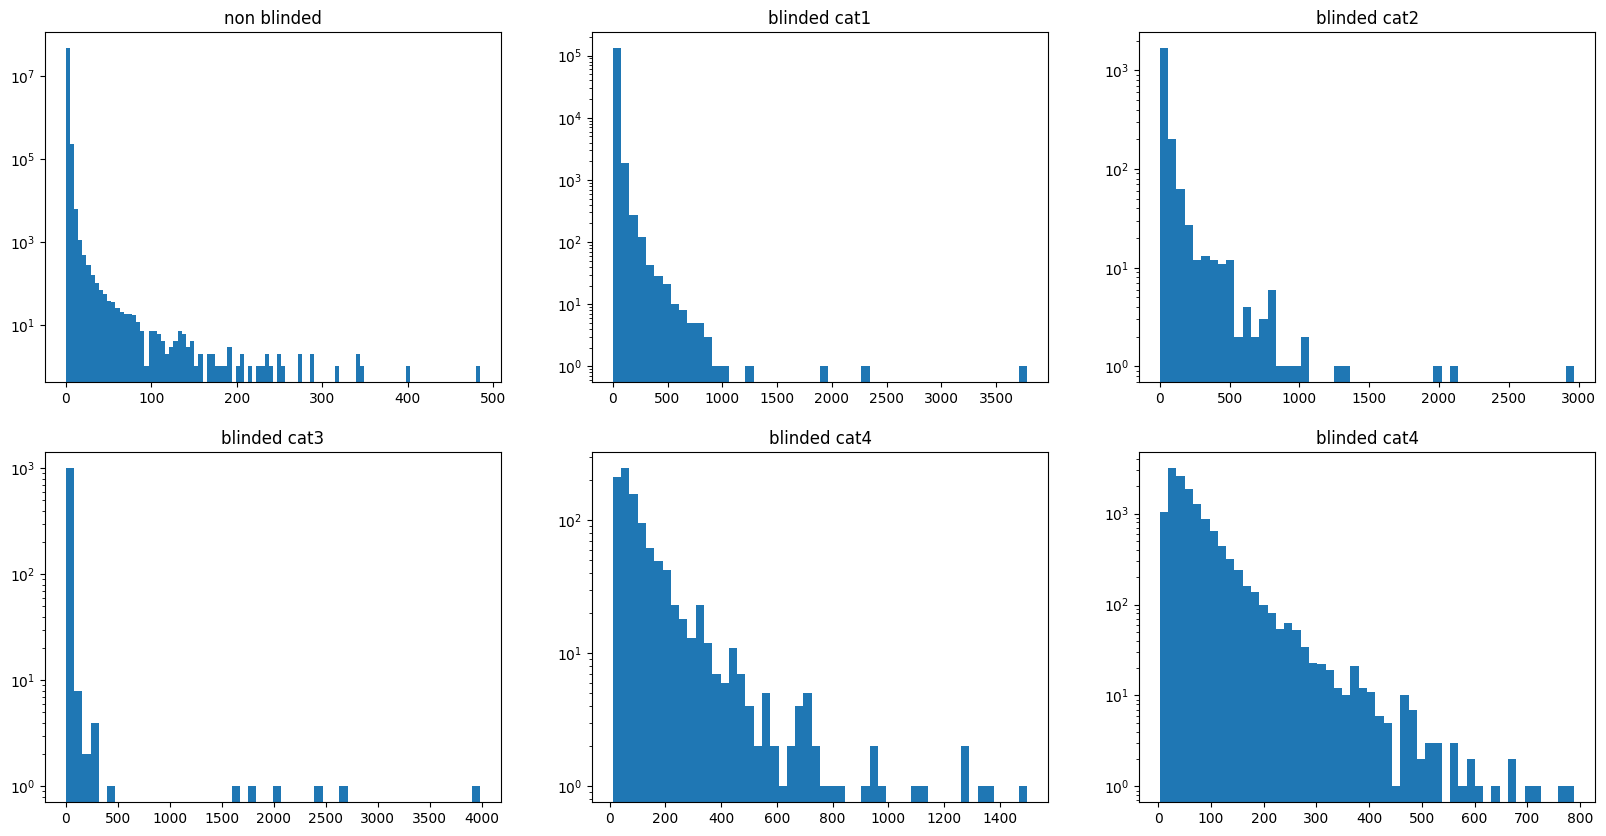

In [26]:

#bl3 = np.where(lb3 == 2)
#bl3 = np.where((lb3 == 1) | (lb3 == 2) | (lb3 == 3) | (lb3 == 4))
#   blind_in_common3 = np.intersect1d(blind_candidate, blind_candidate[bl3[0]])
#blind_in_common3 = np.intersect1d(blind_candidate, bl3[0])
#   print('common blind =', blind_in_common3.size,'out of',bl3[0].size, 'predicted.\nCandidates were',blind_candidate.size)
#   blind_not_in_common3 = np.setdiff1d(blind_candidate[bl3[0]], blind_in_common3, assume_unique=True)
#blind_not_in_common3 = np.setdiff1d(bl3[0], blind_in_common3, assume_unique=True) #returns the value in arr1 which are not in arr2
#   print('not in common :',blind_not_in_common3)

# plot photon hit distribution of cluster 0,1,2 separately
fig, ax = plt.subplots(2,3)

#ax[0].hist(data[np.where(lb3 == 0)[0]].reshape(-1,1),100)
ax[0,0].hist(data[np.where(lb3 == 0)[0]].reshape(-1,1),100)
ax [0,0].set_yscale('log')
ax[0,0].set_title('non blinded')

#ax[1].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax[0,1].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax [0,1].set_yscale('log')
ax[0,1].set_title('blinded cat1')

ax[0,2].hist(data[np.where(lb3 == 2)[0]].reshape(-1,1),50)
#ax[2].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax [0,2].set_yscale('log')
ax[0,2].set_title('blinded cat2')

ax[1,0].hist(data[np.where(lb3 == 3)[0]].reshape(-1,1),50)
#ax[2].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax [1,0].set_yscale('log')
ax[1,0].set_title('blinded cat3')

ax[1,1].hist(data[np.where(lb3 == 4)[0]].reshape(-1,1),50)
#ax[2].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax [1,1].set_yscale('log')
ax[1,1].set_title('blinded cat4')

ax[1,2].hist(data[np.where(lb3 == 7)[0]].reshape(-1,1),50)
#ax[2].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax [1,2].set_yscale('log')
ax[1,2].set_title('blinded cat4')

fig.set_figwidth(20)
fig.set_figheight(10)

In [10]:
#np.where(lb3 == 4)[0]

In [12]:
blind = data[np.where((lb3 == 1) | (lb3 == 2) | (lb3 == 3) | (lb3 == 4) | (lb3 == 5) | (lb3 == 6))]
not_blind = data[np.where(lb3 == 0)]

index_b = np.empty(0)
index_nb = np.empty(0)

for img in blind:
    if np.max(img)/np.mean(img) > 7:
        index_b = np.append(index_b, 1)
    else :
        index_b = np.append(index_b, 0)

print(index_b[index_b == 1].size, 'over', blind.shape[0])
filtered_blind = blind[np.where(index_b == 1)]
#print(np.where(index_b == 1))

for img in not_blind:
    if (np.amax(img) > 40):
        if (np.amax(img)/np.mean(img) > 7):
            index_nb = np.append(index_nb, 1)
        else :
            index_nb = np.append(index_nb, 0) 
    else :
        index_nb = np.append(index_nb, 0) 
        
print(index_nb[index_nb == 1].size, 'over', not_blind.shape[0])
filtered_not_blind = not_blind[np.where(index_nb == 1)]
#print(np.where(index_nb == 1))

409 over 1284
100 over 45684


### Plot photon distribution for 1 camera

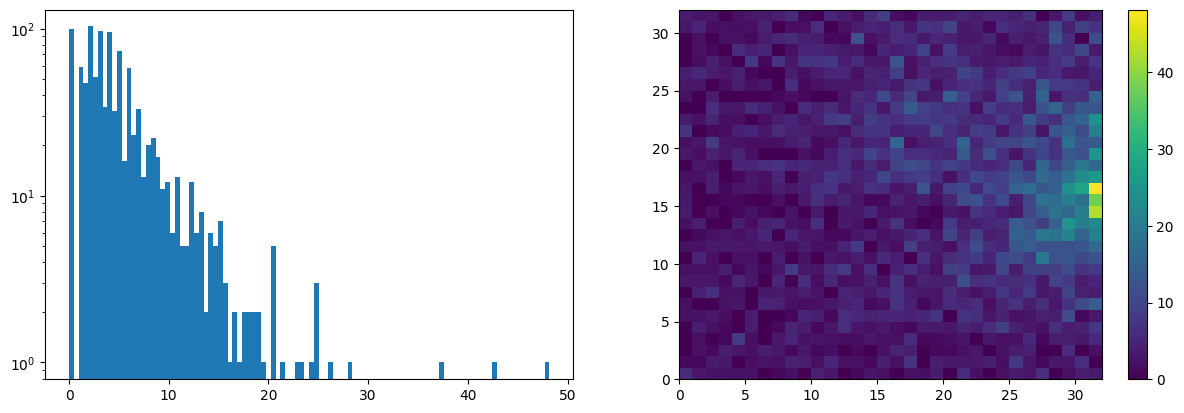

In [41]:
data_num = 15479

fig, ax = plt.subplots(1,2)
ax[0].hist(not_blind[data_num],100)
ax[0].set_yscale('log')

#camera = np.reshape(df.iloc[162].pixels, (32,32))
cam = ax[1].pcolormesh(not_blind[data_num].reshape(32,32))
#cam = ax[1].pcolormesh(arr3d[data_num])
plt.colorbar(cam)

fig.set_figwidth(15)

### save cameras to pdf

In [14]:
write_pdf = True
# if (filtered_blind.shape[0] < 1000) & (write_pdf) :
#     pdf = PdfPages('blinded_filtered.pdf')
#     for num in filtered_blind:
#         fig = plt.figure()
#         cam = plt.pcolormesh(num.reshape(32,32))
#         plt.colorbar(cam)
#         #plt.title('cam-'+str(num))
#         pdf.savefig(fig)
#         plt.close()
#     pdf.close()
    
if (blind.shape[0] < 1500) & (write_pdf) :
    pdf = PdfPages('blinded.pdf')
    for num in blind:
        fig = plt.figure()
        cam = plt.pcolormesh(num.reshape(32,32))
        plt.colorbar(cam)
        #plt.title('cam-'+str(num))
        pdf.savefig(fig)
        plt.close()
    pdf.close()

#### Save to pickle file

In [13]:
save = True
if save:
    np.save('blind_cameras_dataset/blinded_filtered.npy',filtered_blind)
    np.save('blind_cameras_dataset/blinded.npy',blind)

#### Read from pickle file

In [14]:
read = False
if read:
    with open('blind_cameras_dataset/blinded.npy', 'rb') as f:
        load_blind = np.load(f)